<a href="https://colab.research.google.com/github/douglasmmachado/Battery_SoC/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_data = pd.read_csv('https://raw.githubusercontent.com/douglasmmachado/Battery_SoC/main/1%20-%20NN/data.csv')

In [ ]:
df_data.info()
df_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72832 entries, 0 to 72831
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   current_measured  72831 non-null  float64
 1   voltage_measured  72832 non-null  float64
 2   voc               72831 non-null  float64
 3   rint              72831 non-null  float64
 4   zeta              72831 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB


,current_measured,voltage_measured,voc,rint,zeta
56312,0.97349,3.6630,3.7221,0.060759,2.8858
15820,0.89597,3.9145,3.9684,0.060169,74.6030
64615,0.96107,3.8690,3.9277,0.061012,55.5400
25115,0.98461,3.8210,3.8803,0.060253,29.1850
10009,1.14980,3.8634,3.9325,0.060084,59.9090


<Axes: >

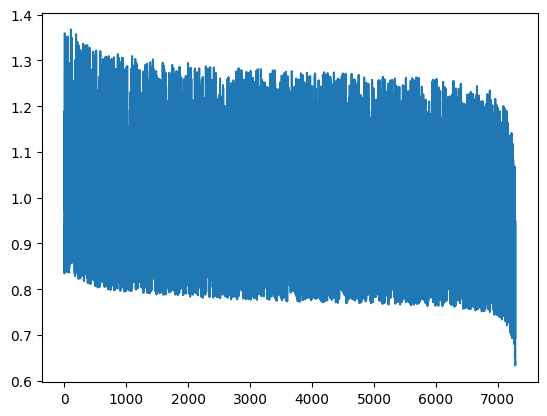

In [ ]:
df_current_measured_plot = df_data.current_measured[0:7284]
df_current_measured_plot.plot()

<Axes: title={'center': 'Load voltage over time'}>

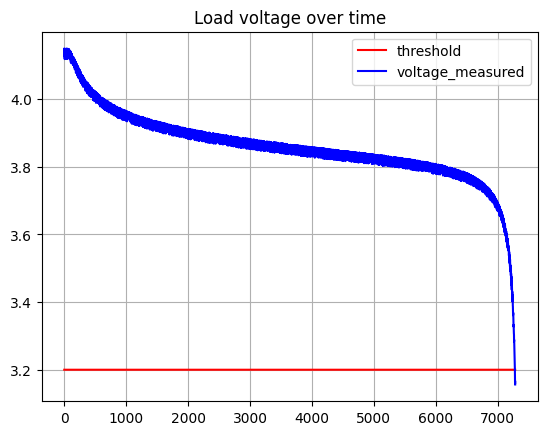

In [ ]:
df_voltage_measured = df_data.voltage_measured[0:7284]
df_yline = pd.DataFrame([3.2 for x in range(len(df_voltage_measured))], columns=["threshold"]).plot(color='r')
df_voltage_measured.plot(title='Load voltage over time', grid=True, legend=True, color='b')

<Axes: title={'center': 'Open circuit voltage over time'}>

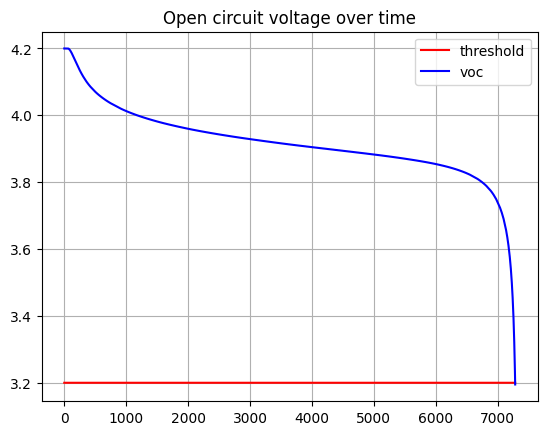

In [ ]:
df_voc = df_data.voc[0:7284]
df_yline = pd.DataFrame([3.2 for x in range(len(df_voc))], columns=["threshold"]).plot(color='r')
df_voc.plot(title='Open circuit voltage over time', grid=True, legend=True, color='b')

<Axes: title={'center': 'State of charge over time'}>

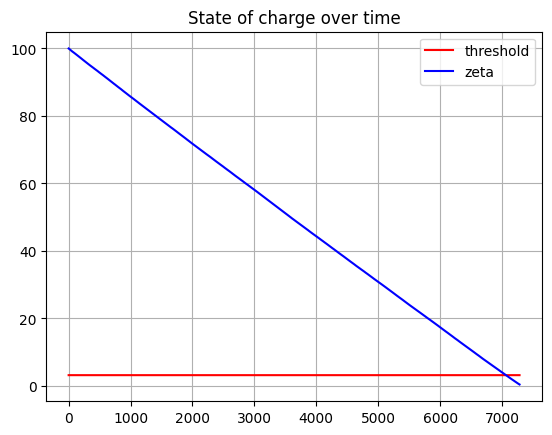

In [ ]:
df_zeta = df_data.zeta[0:7284]
df_yline = pd.DataFrame([3.2 for x in range(len(df_zeta))], columns=["threshold"]).plot(color='r')
df_zeta.plot(title='State of charge over time', grid=True, legend=True, color='b')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_data[['current_measured','voltage_measured']],df_data[['voc','rint','zeta']], train_size=0.5)

36416